# 데이터 불러오기

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

customer = pd.read_csv("customer_join.csv")
uselog_months = pd.read_csv("uselog_months.csv")

In [2]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,4,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,5,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,5,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,5,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,5,1,2019-04-30,47


In [3]:
uselog_months.head()

,customer_id,y/m,num_visits
0,AS002855,201804,4
1,AS002855,201805,5
2,AS002855,201806,5
3,AS002855,201807,5
4,AS002855,201808,3


# 데이터 가공

## 트리모형의 인풋으로 들어갈 데이터 정의

- 현재 ~ 1개월 전의 이용 이력 사용

In [4]:
year_months = list(uselog_months["y/m"].unique())
uselog = pd.DataFrame()

for i in range(1, len(year_months)):
    # 현월의 이용 내역
    filter1 = (uselog_months["y/m"] == year_months[i])    
    tmp = uselog_months.loc[filter1]
    tmp.rename(columns = {"num_visits": "count_current"}, inplace=True)
    
    # 한달 전의 이용 내역
    filter2 = (uselog_months["y/m"] == year_months[i-1])  
    tmp_before = uselog_months.loc[filter2]
    del tmp_before["y/m"]
    tmp_before.rename(columns = {"num_visits": "count_previous"}, inplace=True)
    
    # 데이터 쌓기
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)

In [5]:
uselog.head()

,customer_id,y/m,count_current,count_previous
0,AS002855,201805,5,4.0
1,AS009373,201805,4,3.0
2,AS015233,201805,7,NaN
3,AS015315,201805,3,6.0
4,AS015739,201805,5,7.0


In [6]:
uselog.shape

(33851, 4)

## 탈퇴회원

- 월말까지 탈퇴 신청을 하면 그 다음 달 말에 탈퇴한 것으로 집계됨

In [7]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,4,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,5,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,5,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,5,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,5,1,2019-04-30,47


In [8]:
from dateutil.relativedelta import relativedelta

filter1 = (customer["is_deleted"] == 1)
exit_customer = customer[filter1]
exit_customer["exit_date"] = None   # Exit Date 칼럼 추가
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])

# 탈퇴 바로 전월 계산해서 기록
for i in range(len(exit_customer)):
    previous_month = (exit_customer["end_date"].iloc[i] - relativedelta(months=1))
    exit_customer["exit_date"].iloc[i] = previous_month
    
exit_customer["y/m"] = pd.to_datetime(exit_customer["exit_date"]).dt.strftime("%Y%m")
uselog["y/m"] = uselog["y/m"].astype(str)

exit_uselog = pd.merge(uselog, exit_customer, on = ["customer_id", "y/m"], how="left")

print(exit_uselog.shape)
exit_uselog.head()

(33851, 23)


,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months,exit_date
0,AS002855,201805,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS009373,201805,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS015233,201805,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AS015315,201805,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AS015739,201805,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 결측치들은 탈퇴하지 않은 회원들임
- 결측치 빼고 다시 정리


In [9]:
exit_uselog = exit_uselog.dropna(subset=["name"])   # subset: Define in which columns to look for missing values

print("탈퇴한 회원 수: {} 명".format(len(exit_uselog.customer_id.unique())))
exit_uselog.head()   # 어떤 특정한 회원이 그만두기 바로 전월의 데이터

탈퇴한 회원 수: 1104 명


,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months,exit_date
19,AS055680,201805,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,2_일반,3.000000,3.0,3.0,3.0,2.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
57,AS169823,201805,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,2_일반,3.000000,3.0,4.0,2.0,4.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
110,AS305860,201805,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,2_일반,3.333333,3.0,5.0,2.0,1.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
128,AS363699,201805,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,2_일반,3.333333,3.0,5.0,2.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
147,AS417696,201805,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,2_일반,2.000000,1.0,4.0,1.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


## 지속회원

In [10]:
filter1 = (customer.is_deleted == 0)
contd_customer = customer[filter1]
contd_uselog = pd.merge(uselog, contd_customer, on=["customer_id"], how='left')

print(contd_uselog.shape)
contd_uselog = contd_uselog.dropna(subset=["name"])  # 이미 탈퇴한 회원의 데이터는 제거
print(contd_uselog.shape)

(33851, 22)
(27422, 22)


In [11]:
contd_uselog.head()

,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months
0,AS002855,201805,5,4.0,XXXX,C03,F,2016-11-01,NaN,CA1,...,6000.0,2_일반,4.500000,5.0,7.0,2.0,5.0,1.0,2019-04-30,29.0
1,AS009373,201805,4,3.0,XX,C01,F,2015-11-01,NaN,CA1,...,10500.0,2_일반,5.083333,5.0,7.0,3.0,5.0,1.0,2019-04-30,41.0
2,AS015233,201805,7,NaN,XXXXX,C01,M,2018-05-13,NaN,CA2,...,10500.0,0_입회비반액할인,7.545455,7.0,11.0,4.0,5.0,1.0,2019-04-30,11.0
3,AS015315,201805,3,6.0,XXXXX,C01,M,2015-07-01,NaN,CA1,...,10500.0,2_일반,4.833333,5.0,7.0,3.0,5.0,1.0,2019-04-30,45.0
4,AS015739,201805,5,7.0,XXXXX,C03,M,2017-06-01,NaN,CA1,...,6000.0,2_일반,5.583333,5.5,8.0,4.0,5.0,1.0,2019-04-30,22.0


- 데이터 불균형으로 인해 회원당 한개의 정보만 반영 (언더샘플링)

In [12]:
contd_uselog = contd_uselog.sample(frac=1).reset_index(drop=True)  # 데이터프레임 재배열 (행 기준))
contd_uselog = contd_uselog.drop_duplicates(subset = "customer_id")  # 고객번호를 기준으로 중복치 제거
print(contd_uselog.shape)
contd_uselog.head()

(2842, 22)


,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months
0,PL907890,201812,8,6.0,XXXXXX,C01,F,2017-03-01,NaN,CA1,...,10500.0,2_일반,5.750000,6.0,9.0,2.0,5.0,1.0,2019-04-30,25.0
1,GD589615,201806,5,4.0,XX,C01,F,2015-10-01,NaN,CA1,...,10500.0,2_일반,5.083333,5.0,7.0,4.0,5.0,1.0,2019-04-30,42.0
2,AS993100,201811,7,10.0,XXXX,C01,M,2018-08-04,NaN,CA1,...,10500.0,2_일반,8.375000,7.5,12.0,7.0,5.0,1.0,2019-04-30,8.0
3,HI368031,201805,8,10.0,XXXX,C03,M,2018-04-03,NaN,CA3,...,6000.0,1_입회비무료,7.416667,8.0,10.0,3.0,5.0,1.0,2019-04-30,12.0
4,TS945403,201811,10,8.0,XXXX,C02,F,2018-09-10,NaN,CA1,...,7500.0,2_일반,8.571429,9.0,10.0,6.0,5.0,1.0,2019-04-30,7.0


## 탈퇴회원과 지속회원의 데이터 결합

In [13]:
predict_data = pd.concat([exit_uselog, contd_uselog], ignore_index=True)
print(predict_data.shape)
predict_data.head()

(3946, 23)


,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,campaign_name,mean,median,max,min,count,routine_fig,calc_date,membership_months,exit_date
0,AS055680,201805,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30 00:00:00,CA1,...,2_일반,3.000000,3.0,3.0,3.0,2.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00
1,AS169823,201805,2,3.0,XX,C01,M,2017-11-01,2018-06-30 00:00:00,CA1,...,2_일반,3.000000,3.0,4.0,2.0,4.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00
2,AS305860,201805,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30 00:00:00,CA1,...,2_일반,3.333333,3.0,5.0,2.0,1.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00
3,AS363699,201805,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30 00:00:00,CA1,...,2_일반,3.333333,3.0,5.0,2.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00
4,AS417696,201805,1,4.0,XX,C03,F,2017-09-01,2018-06-30 00:00:00,CA1,...,2_일반,2.000000,1.0,4.0,1.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00


In [14]:
predict_data.columns

Index(['customer_id', 'y/m', 'count_current', 'count_previous', 'name',
       'class', 'gender', 'start_date', 'end_date', 'campaign_id',
       'is_deleted', 'class_name', 'price', 'campaign_name', 'mean', 'median',
       'max', 'min', 'count', 'routine_fig', 'calc_date', 'membership_months',
       'exit_date'],
      dtype='object')

## 재적 기간 추가

- 시계열 자료이기 때문에 현재 연월 (y/m)과 등록 연월의 차이를 바탕으로 재적 기간 칼럼을 추가적으로 생성해서 이용

In [15]:
predict_data["period"] = 0   # 재적 기간 칼럼 추가

for i in range(len(predict_data)):
    now_date = pd.to_datetime(predict_data["y/m"].iloc[i], format="%Y%m")
    start_date = pd.to_datetime(predict_data["start_date"].iloc[i])
    delta = relativedelta(now_date, start_date)
    predict_data["period"].iloc[i] = int(delta.years * 12 + delta.months)
    
predict_data.head()

,customer_id,y/m,count_current,count_previous,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,count,routine_fig,calc_date,membership_months,exit_date,period
0,AS055680,201805,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30 00:00:00,CA1,...,3.000000,3.0,3.0,3.0,2.0,0.0,2018-06-30,3.0,2018-05-30 00:00:00,2
1,AS169823,201805,2,3.0,XX,C01,M,2017-11-01,2018-06-30 00:00:00,CA1,...,3.000000,3.0,4.0,2.0,4.0,1.0,2018-06-30,7.0,2018-05-30 00:00:00,6
2,AS305860,201805,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30 00:00:00,CA1,...,3.333333,3.0,5.0,2.0,1.0,0.0,2018-06-30,12.0,2018-05-30 00:00:00,11
3,AS363699,201805,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30 00:00:00,CA1,...,3.333333,3.0,5.0,2.0,2.0,0.0,2018-06-30,4.0,2018-05-30 00:00:00,3
4,AS417696,201805,1,4.0,XX,C03,F,2017-09-01,2018-06-30 00:00:00,CA1,...,2.000000,1.0,4.0,1.0,1.0,0.0,2018-06-30,9.0,2018-05-30 00:00:00,8


## 결측치 제거

- 트리모형을 사용하기 위해서는 결측치가 존재하면 안됨.
- 결측치를 제거하도록 하자

In [16]:
predict_data.isnull().sum()

customer_id             0
y/m                     0
count_current           0
count_previous        253
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
count                   0
routine_fig             0
calc_date               0
membership_months       0
exit_date            2842
period                  0
dtype: int64

- count_previous 칼럼에 결측치가 있는 경우는 특정 로그가 기록된 달에 신규로 가입한 회원들의 정보임
- 제거하도록 하자

In [17]:
predict_data = predict_data.dropna(subset = ["count_previous"])
predict_data.isnull().sum()

customer_id             0
y/m                     0
count_current           0
count_previous          0
name                    0
class                   0
gender                  0
start_date              0
end_date             2641
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
count                   0
routine_fig             0
calc_date               0
membership_months       0
exit_date            2641
period                  0
dtype: int64

## 카테고리 변수 처리

- 캠페인, 회원구분, 성별을 더미변수화

In [18]:
predict_data.columns

Index(['customer_id', 'y/m', 'count_current', 'count_previous', 'name',
       'class', 'gender', 'start_date', 'end_date', 'campaign_id',
       'is_deleted', 'class_name', 'price', 'campaign_name', 'mean', 'median',
       'max', 'min', 'count', 'routine_fig', 'calc_date', 'membership_months',
       'exit_date', 'period'],
      dtype='object')

In [19]:
# 트리모델에 피팅할 데이터 정의 (종속변수: is_deleted)

target_cols = ["campaign_name", "class_name", "gender", "count_current", "count_previous",
              "routine_fig", "period", "is_deleted"]

predict_data = predict_data[target_cols]

In [20]:
predict_data.head()

,campaign_name,class_name,gender,count_current,count_previous,routine_fig,period,is_deleted
0,2_일반,0_종일,M,3,3.0,0.0,2,1.0
1,2_일반,0_종일,M,2,3.0,1.0,6,1.0
2,2_일반,0_종일,M,5,3.0,0.0,11,1.0
3,2_일반,0_종일,M,5,3.0,0.0,3,1.0
4,2_일반,2_야간,F,1,4.0,0.0,8,1.0


In [21]:
# 카테고리 변수들 더미변수화
predict_data = pd.get_dummies(predict_data)
predict_data.head()

,count_current,count_previous,routine_fig,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,campaign_name_2_일반,class_name_0_종일,class_name_1_주간,class_name_2_야간,gender_F,gender_M
0,3,3.0,0.0,2,1.0,0,0,1,1,0,0,0,1
1,2,3.0,1.0,6,1.0,0,0,1,1,0,0,0,1
2,5,3.0,0.0,11,1.0,0,0,1,1,0,0,0,1
3,5,3.0,0.0,3,1.0,0,0,1,1,0,0,0,1
4,1,4.0,0.0,8,1.0,0,0,1,0,0,1,1,0


In [22]:
# 정보량이 겹치는 열들을 삭제
predict_data = predict_data.drop(["campaign_name_2_일반", "class_name_2_야간", "gender_M"], axis=1)
predict_data.head()

,count_current,count_previous,routine_fig,period,is_deleted,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
0,3,3.0,0.0,2,1.0,0,0,1,0,0
1,2,3.0,1.0,6,1.0,0,0,1,0,0
2,5,3.0,0.0,11,1.0,0,0,1,0,0
3,5,3.0,0.0,3,1.0,0,0,1,0,0
4,1,4.0,0.0,8,1.0,0,0,0,0,1


# 랜덤포레스트 모델 정의

## 학습/테스트 데이터 분할

In [23]:
from sklearn.model_selection import train_test_split

exit = predict_data[predict_data.is_deleted == 1]
remaining = predict_data[predict_data.is_deleted == 0].sample(len(exit))  # 데이터 균형을 위해 언더샘플링

X = pd.concat([exit, remaining], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
# 나중에 예측을 위해 사용할 데이터 약간만 빼놓기
X_test, X_pred, y_test, y_pred = train_test_split(X_test, y_test, train_size = 0.99)

## 하이퍼파라미터 튜닝 X

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# 랜덤포레스트 모델 정의
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)

# 5 fold CV를 통해 모델 평가
scoring = ['f1','precision','recall', "accuracy"] 
scores = cross_validate(rf_model, X_train, y_train,
                          scoring=scoring, cv=5, return_train_score=False)

import numpy as np

print("Mean F1 Score: {:.3f}".format(np.mean(scores["test_f1"])))
print("Mean Precision Score: {:.3f}".format(np.mean(scores["test_precision"])))
print("Mean Recall Score: {:.3f}".format(np.mean(scores["test_recall"])))
print("Mean Accuracy Score: {:.3f}".format(np.mean(scores["test_accuracy"])))

Mean F1 Score: 0.962
Mean Precision Score: 0.964
Mean Recall Score: 0.959
Mean Accuracy Score: 0.962


## Grid Search를 이용한 하이퍼파라미터 튜닝

In [26]:
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "n_estimators": [50, 100, 150, 200],
    "max_samples": [None, 0.8, 0.9, 1],
    "max_features": ["auto", "sqrt", "log2"]
}

GridCV = GridSearchCV(rf_model, param_grid=hyperparams, cv=5, verbose=1)
GridCV.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   27.6s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'max_samples': [None, 0.8, 0.9, 1],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=1)

In [27]:
GridCV.best_params_

{'max_features': 'auto', 'max_samples': 0.9, 'n_estimators': 50}

In [28]:
# 위에서 구한 최적의 하이퍼파라미터 이용해서 모델 정의
rf_tuned = RandomForestClassifier(**GridCV.best_params_, random_state=0, n_jobs= -1)

# 5 fold CV를 통해 모델 평가
scoring = ['f1','precision','recall', "accuracy"] 
scores = cross_validate(rf_tuned, X_train, y_train,
                          scoring=scoring, cv=5, return_train_score=False)

print("Mean F1 Score: {:.3f}".format(np.mean(scores["test_f1"])))
print("Mean Precision Score: {:.3f}".format(np.mean(scores["test_precision"])))
print("Mean Recall Score: {:.3f}".format(np.mean(scores["test_recall"])))
print("Mean Accuracy Score: {:.3f}".format(np.mean(scores["test_accuracy"])))

Mean F1 Score: 0.965
Mean Precision Score: 0.967
Mean Recall Score: 0.963
Mean Accuracy Score: 0.965


- 하이퍼 파라미터 튜닝한 랜포 모델이 미세하게 더 좋은 것을 확인

# 탈퇴회원 예측

In [29]:
rf_tuned.fit(X_train, y_train)
print("Train Accuracy: {:.3f}".format(rf_tuned.score(X_train, y_train)))
print("Test Accuracy: {:.3f}".format(rf_tuned.score(X_test, y_test)))

Train Accuracy: 0.997
Test Accuracy: 0.977


## 변수 중요도

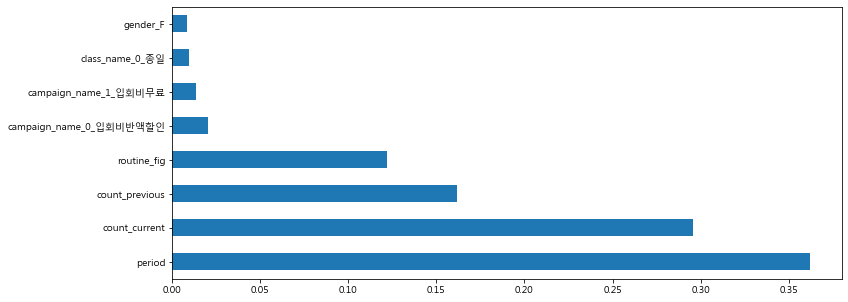

In [30]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 깨짐 방지
font_name = font_manager.FontProperties(fname="/Users/dongwook/Desktop/한글폰트/malgun.ttf").get_name()
rc('font', family=font_name)
plt.figure(figsize=(12,5))

# 변수 중요도 시각화
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)
feature_importances = pd.Series(importances, index=X_train.columns)
feature_importances.nlargest(8).plot(kind='barh')
plt.show()

In [31]:
pd.DataFrame({"feature_names": X.columns, "coefficient": importances})

,feature_names,coefficient
0,count_current,0.295543
1,count_previous,0.161591
2,routine_fig,0.122098
3,period,0.362062
4,campaign_name_0_입회비반액할인,0.020126
5,campaign_name_1_입회비무료,0.013569
6,class_name_0_종일,0.009434
7,class_name_1_주간,0.007161
8,gender_F,0.008417


# 예측 모델 함수화

In [32]:
def prediction(model, customer):
    result = model.predict([customer])
    prob = model.predict_proba([customer])
    
    if result == 1:
        print("이 손님은 다음 달에 탈퇴할 것으로 예측됩니다.")
        print("탈퇴할 확률: {}".format(prob[0][1]))
    else:
        print("이 손님은 다음 달에 탈퇴하지 않을 것으로 예측됩니다.")
        print("탈퇴할 확률: {}".format(prob[0][1]))

In [33]:
X_pred

,count_current,count_previous,routine_fig,period,campaign_name_0_입회비반액할인,campaign_name_1_입회비무료,class_name_0_종일,class_name_1_주간,gender_F
1965,7,6.0,1.0,18,1,0,1,0,1
845,4,5.0,0.0,1,0,0,0,1,1
1997,8,5.0,1.0,14,0,1,0,1,1
591,5,3.0,1.0,6,0,1,0,1,0
1023,5,2.0,1.0,9,0,1,1,0,0
1631,2,4.0,1.0,30,0,0,0,0,1


In [34]:
# 예시 1
example_customer = X_pred.iloc[0, :]
prediction(rf_tuned, example_customer)

이 손님은 다음 달에 탈퇴하지 않을 것으로 예측됩니다.
탈퇴할 확률: 0.04


In [35]:
# 예시 2
example_customer = X_pred.iloc[1, :]
prediction(rf_tuned, example_customer)

이 손님은 다음 달에 탈퇴할 것으로 예측됩니다.
탈퇴할 확률: 1.0


In [36]:
# 예시 3
example_customer = X_pred.iloc[2, :]
prediction(rf_tuned, example_customer)

이 손님은 다음 달에 탈퇴하지 않을 것으로 예측됩니다.
탈퇴할 확률: 0.14
